# Applying OT-intNMF to PBMC

## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Plotting
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../')

In [4]:
# Our packages
import models
import pl

In [5]:
# Maths
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import torch
from torch import optim
from umap import UMAP

In [6]:
# Progress bar
from tqdm.notebook import tqdm

## Load data

In [7]:
mdata = mu.read_h5mu('../datasets/PBMC_10k/preprocessed/pbmc10k.h5mu.gz')

In [8]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

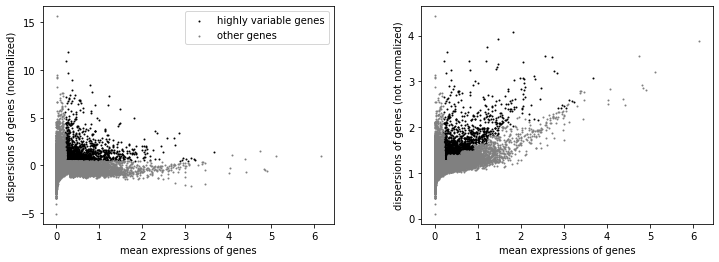

1540

In [9]:
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

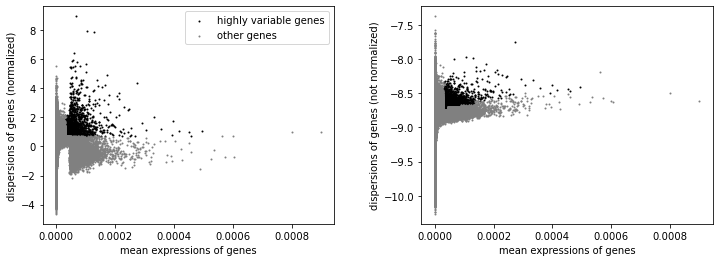

2657

In [10]:
sc.pp.highly_variable_genes(atac, min_mean=3e-5, max_mean=5e-4, min_disp=0.7)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)

## Subsample

In [11]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

In [12]:
sc.pp.subsample(rna, n_obs=1000, random_state=0)
sc.pp.subsample(atac, n_obs=1000, random_state=0)

In [13]:
# Create MuData object with rna and atac
mdata = mu.MuData({'rna': rna, 'atac': atac})

In [14]:
mu.pp.intersect_obs(mdata)
mdata

MuData object with n_obs × n_vars = 1000 × 128106
  var:	'dispersions', 'dispersions_norm', 'highly_variable', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	1000 x 22020
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    atac:	1000 x 106086
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'hvg'

## OT-intNMF

### Train model

In [15]:
# hyperparameters
eps, latent_dim = .05, 20

In [16]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=.08, rho_w=.08, lr=1e-2, eps=eps, decay_rate=1, tol=1e-2)

In [17]:
nmf.fit_transform(mdata, cost='cosine', n_iter_inner=20, n_iter=30, device='cpu')

100%|██████████| 2400/2400 [43:36<00:00,  1.97s/it]  

### Convergence plots

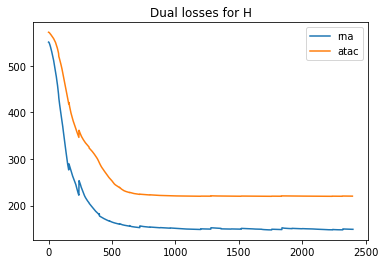

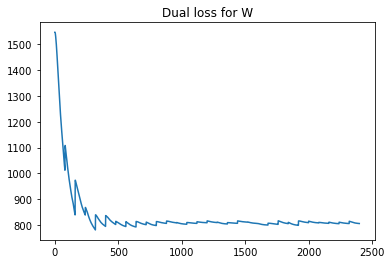

In [18]:
plt.title('Dual losses for H')
for mod in mdata.mod:
    plt.plot(nmf.losses_h[mod])
plt.legend(mdata.mod.keys())
plt.show()

plt.title('Dual loss for W')
plt.plot(nmf.losses_w)
plt.show()

### Viz

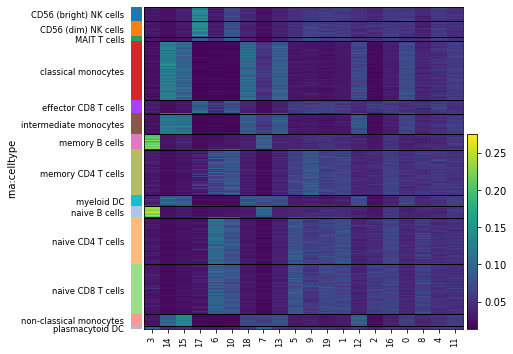

In [20]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

100%|██████████| 2400/2400 [43:41<00:00,  1.09s/it]


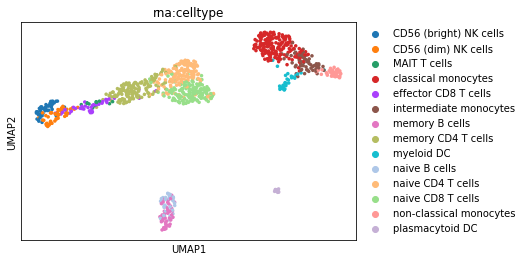

In [21]:
pl.umap(mdata, 'W_OT', 'rna:celltype')